## The Beta Distribution

In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt

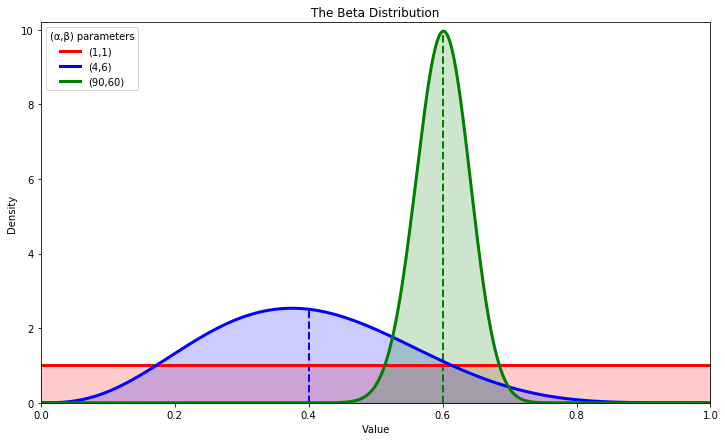

In [2]:
beta = stats.beta

params = [(1, 1),(4,6),(90,60)]
x = np.linspace(0.0, 1.0, 10000)

plt.figure(figsize=(12,7))

colors = ["red","blue","green"]
c_index = 0

for α, β in params:
    y = beta.pdf(x, α, β)
    c = colors[c_index]
    lines = plt.plot(x,y,label = f"({α},{β})",lw = 3, color = c)
    plt.fill_between(x, 0, y, alpha = 0.2, color = c)
    
    if α > 1:
        mean = α/(α+β)
        plt.vlines(mean, 0, beta.pdf(mean, α, β), colors = c, linestyles = "--", lw = 2)    
    
    plt.autoscale(tight=True)
    c_index += 1
    
plt.title('The Beta Distribution')
plt.xlabel('Value')
plt.ylabel('Density')

plt.ylim(0,10.2)
plt.legend(loc = 'upper left', title="(α,β) parameters");

plt.savefig("beta_distribution.png")

# Thompson Sampling

In [7]:
class BernoulliThompsonSocket:
    def __init__(self, q):                
        self.q = q  # the true reward value                
        self.n = 0  # the number of times this socket has been tried       
        self.α = 1  # the number of times this socket returned a charge        
        self.β = 1  # the number of times no charge was returned
    
    # a reward is returned with a probability equal to the true reward probability set for this socket
    def charge(self):        
        return np.random.random() < self.q
                    
    # increase the number of times this socket has been used and update the counts of the number of times
    # the socket has and has not returned a charge (alpha and beta)
    def update(self,R):
        self.n += 1
        self.α += R
        self.β += (1-R)
    
    # return a value sampled from the beta distribution
    def sample(self):
        return np.random.beta(self.α,self.β)

In [8]:
# return the index of the largest value in the supplied list
# - arbitrarily select between the largest values in the case of a tie
# (the standard np.argmax just chooses the first value in the case of a tie)
def random_argmax(value_list):
  """ a random tie-breaking argmax"""
  values = np.asarray(value_list)
  return np.argmax(np.random.random(values.shape) * (values==values.max()))

In [17]:
from IPython.core.pylabtools import figsize

figsize(11.0, 10)

beta = stats.beta
x = np.linspace(0.0,1.0,200)

def plot_sockets(sockets, socket_probabilities ):
    
    trials = sum([socket.n for socket in sockets])
    
    colors = ["green","red","blue"]
    c_index = 0    
    
    for i in range(len(socket_probabilities)):
        
        c = colors[c_index]
        y = beta( sockets[i].α, sockets[i].β )
        p = plt.plot(x, y.pdf(x), lw=2, color=c, label = f'{sockets[i].α-1}/{sockets[i].n}')
        plt.fill_between(x, y.pdf(x), 0, color=c, alpha=0.2 )
        plt.vlines(socket_probabilities[i], 0, y.pdf(socket_probabilities[i]), colors = c, linestyles = "--", lw = 2)
        plt.autoscale(tight = "True")
        plt.title(f"{trials} Trials")
        plt.legend()
        plt.autoscale(tight=True)
        c_index += 1

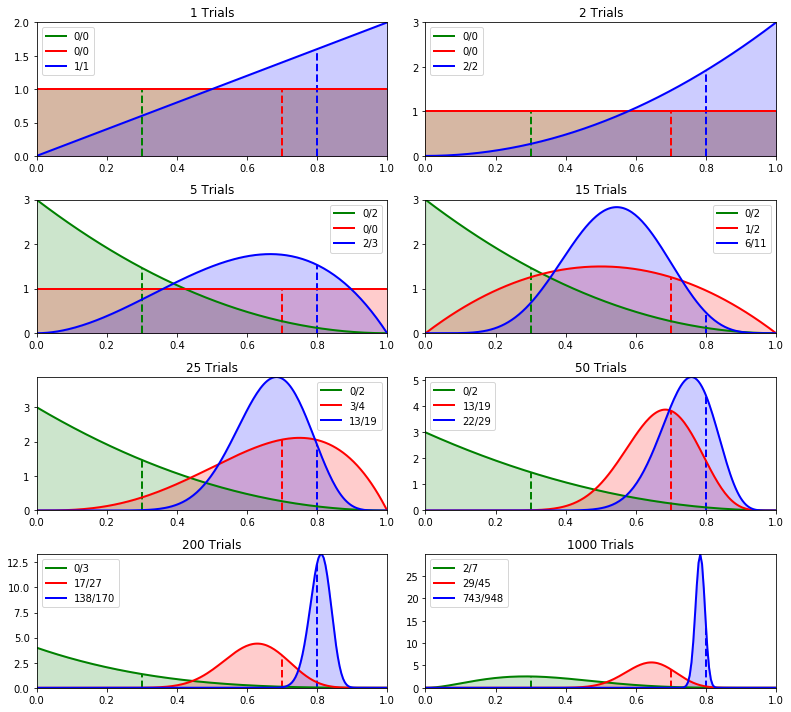

In [31]:
# the probabilities that each socket returns a charge
socket_probabilities = [0.3,0.7,0.8]

sockets = [BernoulliThompsonSocket(p) for p in socket_probabilities]

# draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 600]
draw_samples = [1, 1, 3, 10, 10, 25, 150, 800]

for j,i in enumerate(draw_samples):
    plt.subplot(4, 2, j+1)         
    
    for k in range(i):
        # choose the socket with the current highest sampled value or arbitrary select a socket in the case of a tie            
        socket_index = random_argmax([socket.sample() for socket in sockets])     

        # charge from the chosen socket and update its mean reward value
        reward = sockets[socket_index].charge()
        sockets[socket_index].update(reward)            
        
    plot_sockets(sockets, socket_probabilities)
    
    plt.autoscale(tight = True)
plt.tight_layout()

plt.savefig("thompson_sampling.png")

In [180]:
# the probabilities that each socket returns a charge
socket_probabilities = [0.3,0.6,0.8]

# this is the main socket tester
class SocketTester():

    def __init__(self, socket_probabilities ):  
        
        # create the optimistic sockets with a mean value defined by the socket order
        self.sockets = [BernoulliThompsonSocket(p) for p in socket_probabilities]                  
        
        # set the number of sockets equal to the number created
        self.number_of_sockets = len(self.sockets)           

        # the index of the best socket is the last in the socket_order list
        # - this is a one-based value so convert to zero-based
        self.optimal_socket_index = (socket_probabilities[-1] - 1)     
                     
       
    def run( self, number_of_steps ):            
        
        # save data about the run to create a table of estimates
        rewards = np.zeros(shape=(number_of_steps+1, self.number_of_sockets))

        # monitor the total reward obtained over the run
        total_reward = 0

        # monitor the number of times the optimal socket was chosen
        optimal_socket_selected = 0

        # keep a count of the number of times each socket was selected
        selected_socket = np.zeros(shape=(self.number_of_sockets))   
        
        # loop for the specified number of time-steps
        for t in range(number_of_steps):

            # select a socket
            socket_index = self.select_socket(t)

            # charge from the chosen socket and update its mean reward value
            reward = self.sockets[socket_index].charge()
            self.sockets[socket_index].update(reward)

            # update rewards
            rewards[t] = reward

            # update the total reward
            total_reward += reward

            # monitor the number of times the optimal socket was chosen
            if socket_index == self.optimal_socket_index: 
                optimal_socket_selected += 1      

            # increment the count of the number of times the selected socket has been used
            selected_socket[socket_index] += 1

        return estimates, (total_reward/number_of_steps), (optimal_socket_selected/number_of_steps), (selected_socket/number_of_steps)    
    
    
    def select_socket( self, t ):
        """ Thompson Sampling Socket Selection"""
        
        # choose the socket with the current highest sampled value or arbitrary select a socket in the case of a tie            
        socket_index = random_argmax([socket.sample() for socket in self.sockets])               
        
        return socket_index

In [ ]:
# hidden_prob = np.array([0.85, 0.60, 0.75])
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)

draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 600]

for j,i in enumerate(draw_samples):
    plt.subplot(5, 2, j+1) 
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob)
    #plt.legend()
    plt.autoscale(tight = True)
plt.tight_layout()

In [112]:
NUM_TRIALS = 2000
BANDIT_PROBABILITIES = [0.2, 0.5, 0.75]

def plot(sockets, trial):
  x = np.linspace(0, 1, 200)
  for s in sockets:
    y = beta.pdf(x, s.alpha, s.beta)
    plt.plot(x, y, label=f"real p: {s.q:.4f}, win rate = {s.alpha - 1}/{s.n}")
  plt.title(f"Bandit distributions after {trial} trials")
  plt.legend()
  plt.show()

def experiment():
  sockets = [ThompsonPowerSocket(p) for p in BANDIT_PROBABILITIES]

  sample_points = [5,10,20,50,100,200,500,1000,1500,1999]
  rewards = np.zeros(NUM_TRIALS)
  for i in range(NUM_TRIALS):
    # Thompson sampling
    socket_samples = [socket.sample() for socket in sockets]        

    j = random_argmax( socket_samples )

    # plot the posteriors
    if i in sample_points:
      plot(sockets, i)

    # pull the arm for the bandit with the largest sample
    x = sockets[j].charge()

    # update rewards
    rewards[i] = x

    # update the distribution for the bandit whose arm we just pulled
    sockets[j].update(x)

  # print total reward
  print("total reward earned:", rewards.sum())
  print("overall win rate:", rewards.sum() / NUM_TRIALS)
  print("num times selected each bandit:", [socket.n for socket in sockets])

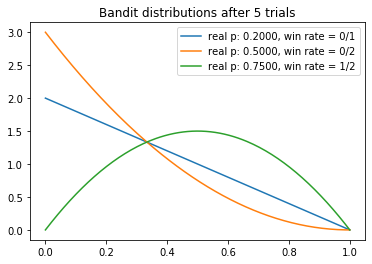

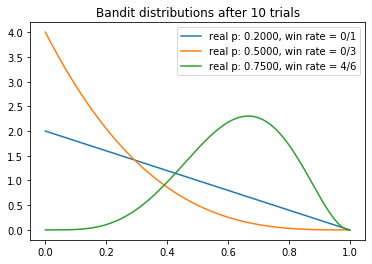

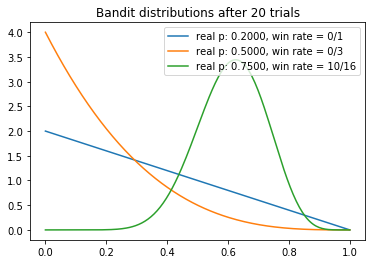

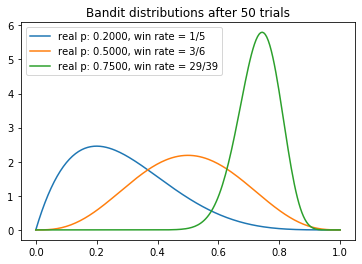

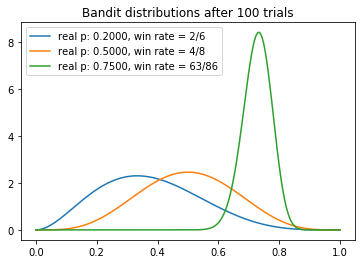

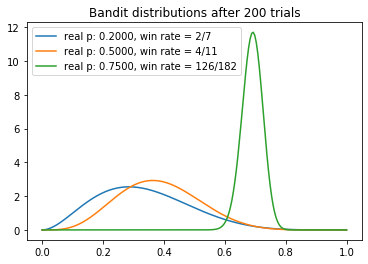

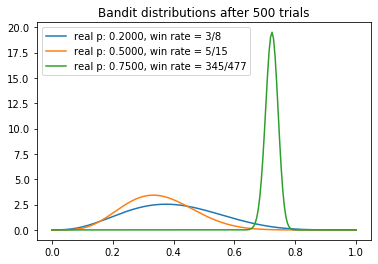

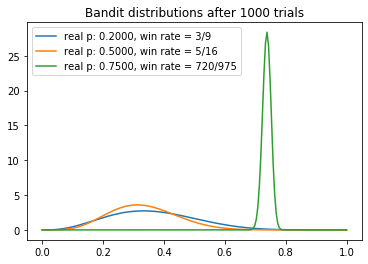

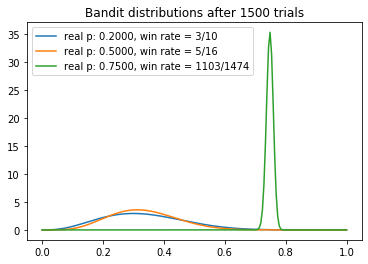

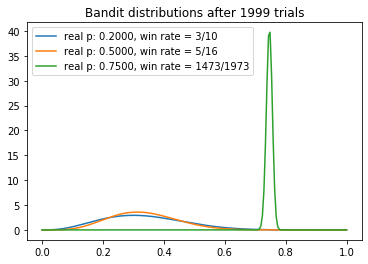

total reward earned: 1482.0
overall win rate: 0.741
num times selected each bandit: [10, 16, 1974]


In [113]:
experiment()

In [122]:
from IPython.core.pylabtools import figsize

figsize(11.0, 10)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

beta = stats.beta
x = np.linspace(0.001,.999,200)

def plot_priors(bayesian_strategy, prob, lw = 3, alpha = 0.2, plt_vlines = True):
    ## plotting function
    wins = bayesian_strategy.wins
    trials = bayesian_strategy.trials
    for i in range(prob.shape[0]):
        y = beta(1+wins[i], 1 + trials[i] - wins[i])
        p = plt.plot(x, y.pdf(x), lw = lw)
        c = p[0].get_markeredgecolor()
        plt.fill_between(x,y.pdf(x),0, color = c, alpha = alpha, 
                         label="underlying probability: %.2f" % prob[i])
        if plt_vlines:
            plt.vlines(prob[i], 0, y.pdf(prob[i]) ,
                       colors = c, linestyles = "--", lw = 2)
        plt.autoscale(tight = "True")
        plt.title("Posteriors After %d pull" % bayesian_strategy.N +\
                    "s"*(bayesian_strategy.N > 1))
        plt.autoscale(tight=True)
    return

In [123]:
rand = np.random.rand

class Bandits(object):
    """
    This class represents N bandits machines.

    parameters:
        p_array: a (n,) Numpy array of probabilities >0, <1.

    methods:
        pull( i ): return the results, 0 or 1, of pulling 
                   the ith bandit.
    """
    def __init__(self, p_array):
        self.p = p_array
        self.optimal = np.argmax(p_array)
        
    def pull(self, i):
        #i is which arm to pull
        return np.random.rand() < self.p[i]
    
    def __len__(self):
        return len(self.p)

    
class BayesianStrategy(object):
    """
    Implements a online, learning strategy to solve
    the Multi-Armed Bandit problem.
    
    parameters:
        bandits: a Bandit class with .pull method
    
    methods:
        sample_bandits(n): sample and train on n pulls.

    attributes:
        N: the cumulative number of samples
        choices: the historical choices as a (N,) array
        bb_score: the historical score as a (N,) array
    """
    
    def __init__(self, bandits):
        
        self.bandits = bandits
        n_bandits = len(self.bandits)
        self.wins = np.zeros(n_bandits)
        self.trials = np.zeros(n_bandits)
        self.N = 0
        self.choices = []
        self.bb_score = []

    
    def sample_bandits(self, n=1):
        
        bb_score = np.zeros(n)
        choices = np.zeros(n)
        
        for k in range(n):
            #sample from the bandits's priors, and select the largest sample
            choice = np.argmax(np.random.beta(1 + self.wins, 1 + self.trials - self.wins))
            
            #sample the chosen bandit
            result = self.bandits.pull(choice)
            
            #update priors and score
            self.wins[choice] += result
            self.trials[choice] += 1
            bb_score[k] = result 
            self.N += 1
            choices[k] = choice
            
        self.bb_score = np.r_[self.bb_score, bb_score]
        self.choices = np.r_[self.choices, choices]
        return

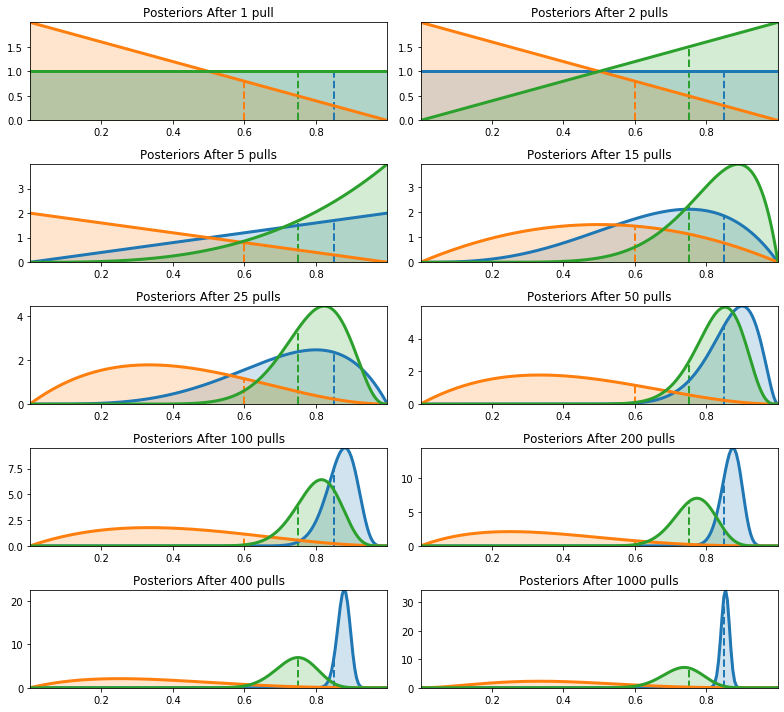

In [124]:
hidden_prob = np.array([0.85, 0.60, 0.75])
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)

draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 600]

for j,i in enumerate(draw_samples):
    plt.subplot(5, 2, j+1) 
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob)
    #plt.legend()
    plt.autoscale(tight = True)
plt.tight_layout()

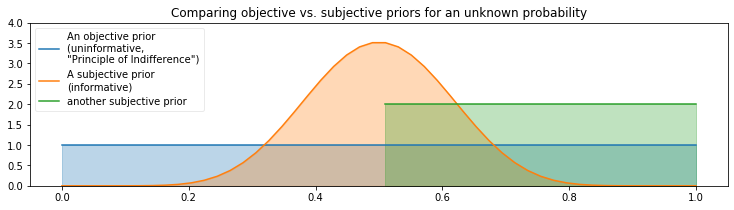

In [119]:
figsize(12.5,3)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

x = np.linspace(0,1)
y1, y2 = stats.beta.pdf(x, 1,1), stats.beta.pdf(x, 10,10)

p = plt.plot(x, y1, 
    label='An objective prior \n(uninformative, \n"Principle of Indifference")')
plt.fill_between(x, 0, y1, color = p[0].get_color(), alpha = 0.3)

p = plt.plot(x,y2 ,
     label = "A subjective prior \n(informative)")
plt.fill_between(x, 0, y2, color = p[0].get_color(), alpha = 0.3)

p = plt.plot(x[25:], 2*np.ones(25), label = "another subjective prior")
plt.fill_between(x[25:], 0, 2, color = p[0].get_color(), alpha = 0.3)

plt.ylim(0,4)

plt.ylim(0, 4)
leg = plt.legend(loc = "upper left")
leg.get_frame().set_alpha(0.4)
plt.title("Comparing objective vs. subjective priors for an unknown probability");